In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp

import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import json

In [2]:
from tableGAN.utils import create_GAN_data, TabularDataset, Preprocessor
from tableGAN.tableGAN import make_noise, CriticNet, WGAN, GeneratorNet

# Simulation data

In [3]:
X_train = np.array([
np.concatenate( [sp.norm.rvs(loc=x, scale=0.3, size=2000) for x in [-1,0,1]] ),
np.concatenate( [sp.beta.rvs(a, b, size=2000) for a,b in [(0.1,0.1),(1,1),(10,10)]] )]).T

/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


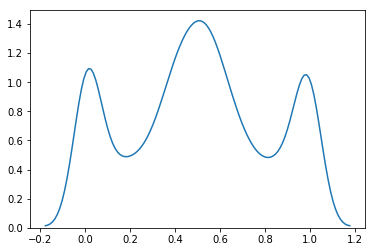

In [4]:
sns.kdeplot(X_train[:,1])
plt.show()

## Train WGAN

In [16]:
# Input to critic is in the shape of the original data
input_dim=2
noise_dim=20

In [17]:
# Save in a list the 1) number of continuous variables, 2) the number of binary variables, 
# 3) a list with the number of levels for each multi-level categorical
#variable_type_counts = [np.sum(cat_levels==0), np.sum(cat_levels==2), cat_levels[cat_levels>2].tolist()]

In [18]:
generator = GeneratorNet(hidden_layers=[128,64,32], noise_dim=noise_dim,
                         n_output_continuous=2,
                         n_output_binary=None,
                         n_output_categorical=None)
#generator = GeneratorNet(noise_dim=100,n_output_continuous=7,n_output_binary=2,n_output_categorical=[3])
critic = CriticNet(input_dim=input_dim, hidden_layers=[128,64,32], dropout = 0)
wgan = WGAN(generator, critic)

In [19]:
batch_size = 64
#learning_rate = 1e-5
critic_rounds = 5
gradient_penalty_coefficient = 10

In [20]:
X_train_tab = TabularDataset(X_train, label=None)
data_loader = DataLoader(X_train_tab, batch_size=batch_size, shuffle=True)

In [21]:
critic_optimizer = Adam(critic.parameters(), lr=1e-4)
generator_optimizer = Adam(generator.parameters(), lr=1e-4)

In [22]:
num_epochs = 10

In [23]:
critic_performance, generator_performance = wgan.train_WGAN(
    data_loader=data_loader, critic_optimizer=critic_optimizer, generator_optimizer=generator_optimizer,
    num_epochs =num_epochs, gradient_penalty_coefficient= gradient_penalty_coefficient,
    critic_rounds=critic_rounds,
    val_data=torch.from_numpy(X_train).float()
) #torch.from_numpy(X_test).float()

-0.026156 | -0.024081
-0.006263 | -0.074007
-0.223955 | -0.059175
0.065518 | 0.102934
0.508120 | 0.508138
0.397754 | 0.319799
0.065226 | 0.056711
-0.184381 | -0.193151
0.151045 | 0.103735
1.344335 | 1.190701
0.814986 | 0.918307
0.576222 | 0.638692
0.475413 | 0.446472
0.083747 | 0.148493
-0.385547 | -0.341282
-0.807117 | -0.610530
1.181100 | 1.246728
0.407131 | 0.370276
-0.045561 | -0.086891
-0.184037 | -0.197322


# Synthetic data evaluation

### Distributional distance

In [13]:
fake = wgan.generator.sample(make_noise(20000, dim=wgan.generator.noise_dim)).detach().numpy()

In [14]:
pd.DataFrame(np.vstack([np.round(np.mean(X_train, axis=0),4), 
                        np.round(np.mean(fake, axis=0),4)]))

,0,1
0,-0.0042,0.4976
1,-0.2771,0.4556


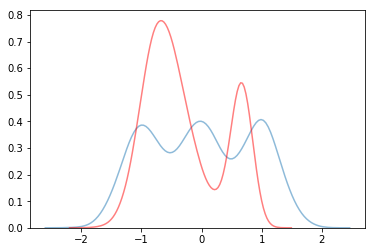

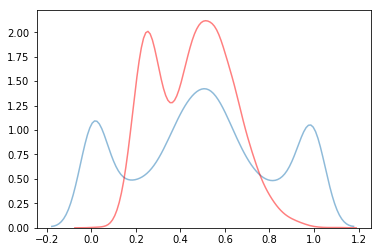

In [15]:
for i in range(2):
    sns.kdeplot(X_train[:,i], alpha=0.5, )
    sns.kdeplot(fake[:,i], alpha=0.5, color="red")
    plt.show()

### Fake/real prediction

In [ ]:
X_fakereal = np.vstack([X_train, 
                        fake])
y_fakereal = np.concatenate([np.zeros(X_train.shape[0]), 
                        np.ones(fake.shape[0])]).flatten()

In [ ]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=100, random_state=123)
model_fakereal = clf.fit(X_fakereal, y_fakereal)

In [ ]:
pred_fakereal = model_fakereal.predict_proba(X_fakereal)[:,1]
roc_auc_score(y_fakereal, pred_fakereal)

In [ ]:
importances = model_fakereal.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_fakereal.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(2):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


## Model performance

In [ ]:
np.sum(y_train==1)

In [ ]:
round(np.sum(y_train==1) / np.sum(y_train==0),2)

In [ ]:
pred = {}
model = {}

In [ ]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=100, random_state=123)

model["org"] = clf.fit(X_train, y_train)
pred["org"] = model["org"].predict_proba(X_test)[:,1]

### GANbalance

In [ ]:
balanced_ratio = 0.1

In [ ]:
#n_samples = np.sum(y_train==0) - np.sum(y_train==1)
n_samples = int(np.sum(y_train==0) * balanced_ratio)

In [ ]:
sample = wgan.generator.sample(make_noise(size=n_samples, dim=wgan.generator.noise_dim)).detach().numpy()

In [ ]:
X_train_upsampled = np.vstack([X_train, 
                               sample]
                                )
y_train_upsampled = np.concatenate([y_train, np.ones(n_samples)])

In [ ]:
model["up"] = clf.fit(X_train_upsampled, y_train_upsampled)
pred["up"] = model["up"].predict_proba(X_test)[:,1]

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks

In [ ]:
#smote_nc = TomekLinks(sampling_strategy=1, random_state=0, n_jobs=20)
#X_cat_train_smote, y_train_smote = smote_nc.fit_resample(X_cat_train, y_train)

In [ ]:
smote_nc = SMOTENC(sampling_strategy = balanced_ratio, categorical_features=np.where(cat_levels>1)[0], random_state=0, n_jobs=20, )
X_cat_train_smote, y_train_smote = smote_nc.fit_resample(X_cat_train, y_train)

In [ ]:
X_train_smote = pd.DataFrame(X_cat_train_smote)
X_train_smote = pd.get_dummies(X_train_smote, columns=X_train_smote.columns[np.where(cat_levels>2)])

In [ ]:
model["smote"] = clf.fit(X_train_smote, y_train_smote)
pred['smote'] = model["smote"].predict_proba(X_test)[:,1]

### Comparison

In [ ]:
{model:roc_auc_score(y_test, pred[model]) for model in pred}